In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import pickle as pkl

import scipy as sp
from scipy.sparse.csgraph import minimum_spanning_tree

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
import community as community_louvain
from wordcloud import WordCloud

In [2]:
temp = pd.read_stata("data/country_sitcproductsection_year.dta")

In [3]:
len(set(list(temp["location_code"])))

249

In [4]:
temp

,location_id,product_id,year,export_value,import_value,global_market_share,export_rpop,sitc_eci,sitc_coi,pci,location_code,sitc_product_code
0,0,0,1988,2.624700e+04,1.152106e+06,1.188888e-07,0.009845,1.405828,-0.393986,-0.748730,ABW,0
1,0,0,1989,1.032738e+06,8.486987e+06,4.416667e-06,0.372328,0.845417,-0.246491,-0.719991,ABW,0
2,0,0,1990,3.590050e+05,3.623491e+07,1.405847e-06,0.118401,-0.242892,-0.676147,-0.713332,ABW,0
3,0,0,1991,5.113930e+05,3.947515e+07,1.935447e-06,0.159386,-0.529015,-0.719439,-0.692131,ABW,0
4,0,0,1992,3.297282e+06,4.571230e+07,1.134521e-05,0.898691,-0.260923,-0.700814,-0.641841,ABW,0
...,...,...,...,...,...,...,...,...,...,...,...,...
128604,201,10,2016,5.055584e+09,4.052759e+09,1.028956e-03,1.079058,0.608136,1.381320,-0.229752,SRB,services
128605,201,10,2017,5.954025e+09,4.855776e+09,1.117176e-03,1.191473,0.593120,1.535527,-0.313508,SRB,services
128606,201,10,2018,7.137170e+09,5.967301e+09,1.221178e-03,1.323918,0.665772,1.552409,-0.409799,SRB,services
128607,201,10,2019,7.754774e+09,6.624753e+09,1.300178e-03,1.432169,0.752386,1.495269,-0.392002,SRB,services


# Data Imports

##### Extract product codes

In [5]:
#SITC revision 2 product code definitions
data_dict = pd.read_json('https://comtrade.un.org/data/cache/classificationS2.json')

In [6]:
data_cross = []
i = 0
for item_def in list(data_dict["results"]):
    if(i >= 2):
        data_cross.append(item_def["text"].split(" - ", 1))
    i = i+1

product_codes = pd.DataFrame(data_cross, columns = ['code', 'product'])

In [7]:
product_codes

,code,product
0,AG1,All 1-digit SITC Rev.2 commodities
1,AG2,All 2-digit SITC Rev.2 commodities
2,AG3,All 3-digit SITC Rev.2 commodities
3,AG4,All 4-digit SITC Rev.2 commodities
4,AG5,All 5-digit SITC Rev.2 commodities
...,...,...
2577,971,"Gold, non-monetary (excluding gold ores and co..."
2578,9710,"Gold, non-monetary (excluding gold ores and co..."
2579,97101,"Gold (including platlnum-plated gold), non-mon..."
2580,97102,"Rolled gold on base metal or silver, unworked ..."


##### Extract Country Codes

In [9]:
country_codes = pd.read_excel("data/ISO3166.xlsx")

In [10]:
country_codes

,English short name,French short name,Alpha-2 code,Alpha-3 code,Numeric
0,Afghanistan,Afghanistan (l'),AF,AFG,4
1,Albania,Albanie (l'),AL,ALB,8
2,Algeria,Algérie (l'),DZ,DZA,12
3,American Samoa,Samoa américaines (les),AS,ASM,16
4,Andorra,Andorre (l'),AD,AND,20
...,...,...,...,...,...
244,Western Sahara*,Sahara occidental (le)*,EH,ESH,732
245,Yemen,Yémen (le),YE,YEM,887
246,Zambia,Zambie (la),ZM,ZMB,894
247,Zimbabwe,Zimbabwe (le),ZW,ZWE,716


##### Extract Trade Data

In [13]:
#import trade data
n1962 = pd.read_stata("data/country_partner_sitcproduct4digit_year_1962.dta")

In [19]:
#rename some columns for join with trade data
country_codes["location_code"] = country_codes["Alpha-3 code"]
country_codes["partner_code"] = country_codes["Alpha-3 code"]
country_codes["country_i"] = country_codes["English short name"]
country_codes["country_j"] = country_codes["English short name"]
product_codes["sitc_product_code"] = product_codes["code"]

In [20]:
#join trade data and descriptions
n1962 = pd.merge(n1962, country_codes[["location_code", "country_i"]],on = ["location_code"])
n1962 = pd.merge(n1962, country_codes[["partner_code", "country_j"]],on = ["partner_code"])
n1962 = pd.merge(n1962, product_codes[["sitc_product_code", "product"]], on = ["sitc_product_code"])

In [22]:
#check that importer, exporter, product combinations are unqiue
#when we perform groupby we do not loose any rows
len(n1962.groupby(["location_code", "partner_code", "sitc_product_code"])["import_value"].sum().reset_index()) == len(n1962)

True

In [23]:
n1962.columns

Index(['location_id', 'partner_id', 'product_id', 'year', 'export_value',
       'import_value', 'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
       'sitc_product_code', 'country_i', 'country_j', 'product'],
      dtype='object')

In [24]:
#flip exports so that we have an import relationshipship, rather than import/export
n1962_imports1 = n1962[['location_id', 'partner_id', 'product_id', 'year',
       'import_value', 'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
       'sitc_product_code', 'country_i', 'country_j', 'product']]
n1962_imports1 = n1962_imports1[n1962_imports1["import_value"] != 0]

In [25]:
n1962_imports2 = n1962[['location_id', 'partner_id', 'product_id', 'year',
       'export_value', 'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
       'sitc_product_code', 'country_i', 'country_j', 'product']]
n1962_imports2["temp1"] = n1962_imports2['partner_code']
n1962_imports2["temp2"] = n1962_imports2['location_code']

n1962_imports2['location_code'] = n1962_imports2["temp1"]
n1962_imports2['partner_code'] = n1962_imports2["temp2"]
n1962_imports2["import_value"] = n1962_imports2["export_value"]
n1962_imports2 = n1962_imports2[n1962_imports2["import_value"] != 0]
n1962_imports2 = n1962_imports1[['location_id', 'partner_id', 'product_id', 'year',
       'import_value', 'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
       'sitc_product_code', 'country_i', 'country_j', 'product']]

In [26]:
n1962 = n1962_imports1.append(n1962_imports2)

In [27]:
n1962

,location_id,partner_id,product_id,year,import_value,sitc_eci,sitc_coi,location_code,partner_code,sitc_product_code,country_i,country_j,product
0,1,18,815,1962.0,3106,-0.629827,-0.654635,AFG,BEL,2690,Afghanistan,Belgium,Old clothing and other old textile articles; rags
1,2,18,815,1962.0,137159,-0.725610,-0.703291,AGO,BEL,2690,Angola,Belgium,Old clothing and other old textile articles; rags
2,15,18,815,1962.0,10884,2.045399,2.510272,AUT,BEL,2690,Austria,Belgium,Old clothing and other old textile articles; rags
3,17,18,815,1962.0,158767,-1.461755,-0.558035,BDI,BEL,2690,Burundi,Belgium,Old clothing and other old textile articles; rags
4,23,18,815,1962.0,236160,0.395243,0.097470,BGR,BEL,2690,Bulgaria,Belgium,Old clothing and other old textile articles; rags
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001446,31,8,733,1962.0,3600,-0.136485,-0.461491,BOL,ARG,0742,Bolivia (Plurinational State of),Argentina,Maté
1001453,64,180,733,1962.0,5468,1.690508,2.832390,DNK,PRY,0742,Denmark,Paraguay,Maté
1001454,8,180,733,1962.0,1011523,-0.275650,-0.526755,ARG,PRY,0742,Argentina,Paraguay,Maté
1001455,230,180,733,1962.0,78141,0.106032,-0.316738,URY,PRY,0742,Uruguay,Paraguay,Maté


# Calculate a network for a given year

### Calculate RCA

In [28]:
#total world exports 
world_exports = n1962.groupby(["sitc_product_code"])["import_value"].sum().reset_index()
world_exports["total_product_world"] = world_exports["import_value"]
world_exports["total_world"] = sum(world_exports["import_value"])
world_exports["avg_frac"] = world_exports["total_product_world"]*1000/world_exports["total_world"]

In [29]:
#total_country exports
country_exports = n1962.groupby(["partner_code","sitc_product_code", "country_j", "product"])["import_value"].sum().reset_index()
country_exports["total_product_country"] = country_exports["import_value"]
country_totals = country_exports.groupby(["partner_code"])["import_value"].sum().reset_index()
country_totals["total_country"] = country_totals["import_value"]
country_exports = pd.merge(country_exports, 
                           country_totals[["partner_code", "total_country"]], on = ["partner_code"])
country_exports["country_frac"] = country_exports["total_product_country"]*1000/country_exports["total_country"]

In [30]:
country_exports

,partner_code,sitc_product_code,country_j,product,import_value,total_product_country,total_country,country_frac
0,AFG,0230,Afghanistan,Butter,7142.0,7142.0,1.582275e+08,0.045138
1,AFG,0251,Afghanistan,....in shell,21698.0,21698.0,1.582275e+08,0.137132
2,AFG,0252,Afghanistan,....not in shell,21698.0,21698.0,1.582275e+08,0.137132
3,AFG,0545,Afghanistan,Other fresh or chilled vegetables,143598.0,143598.0,1.582275e+08,0.907541
4,AFG,0548,Afghanistan,"Vegetable products, roots and tubers, chiefly ...",318804.0,318804.0,1.582275e+08,2.014845
...,...,...,...,...,...,...,...,...
42909,ZAF,9110,South Africa,Postal packages not classified according to kind,2225776.0,2225776.0,2.050027e+09,1.085730
42910,ZAF,9310,South Africa,"Special transactions, commodity not classified...",4341836.0,4341836.0,2.050027e+09,2.117941
42911,ZAF,9410,South Africa,"Animals, live, n.e.s., (including zoo animals,...",114298.0,114298.0,2.050027e+09,0.055754
42912,ZAF,9510,South Africa,"Armoured fighting vehicles, war firearms, ammu...",17808.0,17808.0,2.050027e+09,0.008687


In [31]:
country_exports = pd.merge(country_exports, world_exports[["sitc_product_code", "avg_frac"]],
                          on = ["sitc_product_code"])
country_exports["RCA"] = country_exports["country_frac"]/ country_exports["avg_frac"]

In [32]:
country_exports.sort_values(by = ["RCA"])

,partner_code,sitc_product_code,country_j,product,import_value,total_product_country,total_country,country_frac,avg_frac,RCA
11419,CHE,3330,Switzerland,Crude petroleum and oils obtained from bitumin...,2170.0,2170.0,4.137702e+09,0.000524,26.241283,0.000020
21029,VEN,7841,Venezuela (Bolivarian Republic of),"Chassis fitted with engines, for the motor veh...",276.0,276.0,1.808028e+09,0.000153,5.760556,0.000026
21123,VEN,7842,Venezuela (Bolivarian Republic of),"Bodies (including cabs), for the motor vehicle...",276.0,276.0,1.808028e+09,0.000153,5.760556,0.000026
21217,VEN,7849,Venezuela (Bolivarian Republic of),"Other parts and accessories, n.e.s. of the mot...",276.0,276.0,1.808028e+09,0.000153,4.331206,0.000035
11443,NOR,3330,Norway,Crude petroleum and oils obtained from bitumin...,2244.0,2244.0,1.832332e+09,0.001225,26.241283,0.000047
...,...,...,...,...,...,...,...,...,...,...
9910,NPL,2460,Nepal,Pulpwood (including chips and wood waste),269172.0,269172.0,2.691720e+05,1000.000000,1.243134,804.418636
23608,SOM,0012,Somalia,"Sheep and goats, live",14051858.0,14051858.0,5.343753e+07,262.958579,0.320091,821.511195
2634,MNG,2683,Mongolia,"Fine animal hair, not carded or combed",8587392.0,8587392.0,9.095506e+06,944.135708,0.771663,1223.508294
25411,BDI,2876,Burundi,Tin ores and concentrates,6236936.0,6236936.0,8.055462e+06,774.249323,0.556666,1390.867515


In [33]:
RCA = country_exports[country_exports["RCA"] > 1]

In [34]:
RCA["i"] = RCA["partner_code"]
RCA["country_i"] = RCA["country_j"]
RCA["k"] = RCA["sitc_product_code"]

/tmp/ipykernel_463571/1275121748.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RCA["i"] = RCA["partner_code"]
/tmp/ipykernel_463571/1275121748.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RCA["country_i"] = RCA["country_j"]
/tmp/ipykernel_463571/1275121748.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

In [35]:
product_total_RCA = RCA.groupby(["sitc_product_code", "product"])["partner_code"].count().reset_index()
product_total_RCA["total_comp_advantage"] = product_total_RCA["partner_code"]
product_total_RCA["k"] = product_total_RCA["sitc_product_code"]
product_total_RCA["k_2"] = product_total_RCA["k"]

In [36]:
product_total_RCA

,sitc_product_code,product,partner_code,total_comp_advantage,k,k_2
0,0011,Animals of the bovine species (including buffa...,25,25,0011,0011
1,0012,"Sheep and goats, live",19,19,0012,0012
2,0013,"Swine, live",16,16,0013,0013
3,0014,"Poultry, live (i.e., fowls, ducks, geese, turk...",11,11,0014,0014
4,0015,"Horses, asses, mules and hinnies, live",14,14,0015,0015
...,...,...,...,...,...,...
775,9110,Postal packages not classified according to kind,13,13,9110,9110
776,9310,"Special transactions, commodity not classified...",25,25,9310,9310
777,9410,"Animals, live, n.e.s., (including zoo animals,...",32,32,9410,9410
778,9510,"Armoured fighting vehicles, war firearms, ammu...",7,7,9510,9510


In [37]:
nodes = len(set(product_total_RCA["k"]))
nodes*(nodes-1)/2

303810.0

In [38]:
%%time
conditional_RCA = pd.merge(RCA[["i", "k", "country_i", "product", "RCA"]],
                          RCA[["i", "k", "product", "RCA"]],
                          on = ["i"], 
                          suffixes = ("", "_2"))
conditional_RCA = conditional_RCA[conditional_RCA["k"] != conditional_RCA["k_2"]]

CPU times: user 392 ms, sys: 144 ms, total: 536 ms
Wall time: 532 ms


In [39]:
%%time
conditional_RCA = conditional_RCA.groupby(["k", "product", "k_2", "product_2"])["i"].count().reset_index()

CPU times: user 822 ms, sys: 63.4 ms, total: 885 ms
Wall time: 881 ms


In [40]:
conditional_RCA 

,k,product,k_2,product_2,i
0,0011,Animals of the bovine species (including buffa...,0012,"Sheep and goats, live",10
1,0011,Animals of the bovine species (including buffa...,0013,"Swine, live",6
2,0011,Animals of the bovine species (including buffa...,0014,"Poultry, live (i.e., fowls, ducks, geese, turk...",4
3,0011,Animals of the bovine species (including buffa...,0015,"Horses, asses, mules and hinnies, live",7
4,0011,Animals of the bovine species (including buffa...,0019,Live animals of a kind mainly used for human f...,10
...,...,...,...,...,...
521887,9610,"Coin (other than gold coin), not being legal t...",8999,"Manufactured goods, n.e.s.",2
521888,9610,"Coin (other than gold coin), not being legal t...",9110,Postal packages not classified according to kind,5
521889,9610,"Coin (other than gold coin), not being legal t...",9310,"Special transactions, commodity not classified...",6
521890,9610,"Coin (other than gold coin), not being legal t...",9410,"Animals, live, n.e.s., (including zoo animals,...",9


In [41]:
%%time
#eliminate flipped pairs
filter_df = pd.DataFrame(np.sort(conditional_RCA[["k", "k_2"]].values, axis=1), 
                         index=conditional_RCA[["k", "k_2"]].index, 
                         columns=conditional_RCA[["k", "k_2"]].columns).drop_duplicates() #eliminate flipped pairs

CPU times: user 152 ms, sys: 3.73 ms, total: 156 ms
Wall time: 153 ms


In [42]:
#perform filtering
conditional_RCA = pd.merge(conditional_RCA, filter_df,
                          on = ["k", "k_2"],
                          how = "inner")

In [43]:
conditional_RCA = pd.merge(conditional_RCA, product_total_RCA[["k", "total_comp_advantage"]], on = "k")
conditional_RCA = pd.merge(conditional_RCA, product_total_RCA[["k_2", "total_comp_advantage"]], 
                           on = "k_2", suffixes = ("", "_2"))

In [44]:
conditional_RCA["conditional_prob1"] = conditional_RCA["i"]/conditional_RCA["total_comp_advantage"]
conditional_RCA["conditional_prob2"] = conditional_RCA["i"]/conditional_RCA["total_comp_advantage_2"]

In [45]:
conditional_RCA["prob"] = conditional_RCA[["conditional_prob1", "conditional_prob2"]].min(axis = 1)

In [46]:
conditional_RCA.sort_values(by = ["prob"])

,k,product,k_2,product_2,i,total_comp_advantage,total_comp_advantage_2,conditional_prob1,conditional_prob2,prob
242523,2924,Plants and parts (including seeds and fruit) o...,7783,Electrical equipment for internal combustion e...,1,53,8,0.018868,0.125000,0.018868
191908,2924,Plants and parts (including seeds and fruit) o...,8935,"Articles of electric lighting, of the material...",1,53,11,0.018868,0.090909,0.018868
79400,2924,Plants and parts (including seeds and fruit) o...,6732,"Bars and rods (excluding wire rod), of iron or...",1,53,7,0.018868,0.142857,0.018868
108226,2924,Plants and parts (including seeds and fruit) o...,7361,Metal cutting machine-tools,1,53,6,0.018868,0.166667,0.018868
134452,2924,Plants and parts (including seeds and fruit) o...,7741,Electro-medical apparatus (other than radlolog...,1,53,10,0.018868,0.100000,0.018868
...,...,...,...,...,...,...,...,...,...,...
235736,7264,Printing presses,7268,Bookbinding machinery (including book sewing m...,6,6,6,1.000000,1.000000,1.000000
235735,7263,"Machinery, apparatus and accessories for type-...",7268,Bookbinding machinery (including book sewing m...,6,6,6,1.000000,1.000000,1.000000
200684,8973,"Jewellery of gold, silver or platinum group me...",8974,Other articles of precious metal or rolled pre...,9,9,9,1.000000,1.000000,1.000000
52114,6514,Yarn containing 85% or more by weight of synth...,6516,"Yarn of discontinuous synthetic fibres, contai...",10,10,10,1.000000,1.000000,1.000000


In [47]:
#fraction of non-existent edges: 
edges = nodes*(nodes-1)/2
1 - len(conditional_RCA)/edges

0.1410881801125704

In [48]:
len(conditional_RCA[conditional_RCA["prob"] < 0.1])/edges

0.18490503933379415

In [49]:
len(conditional_RCA[conditional_RCA["prob"] < 0.2])/edges

0.4284092031203713

### Transform RCA into matrix with edges 

### Look at MST
References:
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csgraph.minimum_spanning_tree.html
- https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.convert_matrix.to_scipy_sparse_matrix.html#networkx.convert_matrix.to_scipy_sparse_matrix

In [50]:
%%time
conditional_RCA["weight"] = conditional_RCA["prob"]*-100
G=nx.from_pandas_edgelist(conditional_RCA, "k", "k_2", ["weight"])

CPU times: user 494 ms, sys: 31.7 ms, total: 526 ms
Wall time: 520 ms


In [51]:
A = nx.to_scipy_sparse_matrix(G)

In [52]:
A.toarray().astype(np.float64)

array([[  0.        , -40.        , -24.        , ..., -31.25      ,
         -4.        ,  -8.        ],
       [-40.        ,   0.        , -15.78947368, ..., -28.125     ,
         -5.26315789, -15.78947368],
       [-24.        , -15.78947368,   0.        , ..., -18.75      ,
        -18.75      ,   0.        ],
       ...,
       [-31.25      , -28.125     , -18.75      , ...,   0.        ,
         -3.125     , -28.125     ],
       [ -4.        ,  -5.26315789, -18.75      , ...,  -3.125     ,
          0.        ,  -5.88235294],
       [ -8.        , -15.78947368,   0.        , ..., -28.125     ,
         -5.88235294,   0.        ]])

In [53]:
MST = minimum_spanning_tree(A)

In [54]:
MST.toarray()

array([[  0., -40.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

In [55]:
MST_matrix = MST.toarray().astype(np.float64)

In [56]:
check = list(MST_matrix[2])
set(check)

{-57.89473684210527, 0.0}

In [57]:
def connected_nodes(MST_matrix, index):
    check = list(MST_matrix[index])
    
    connections = list(set(check))
    
    connected_list = []
    connected_list.append(list(G.nodes())[index])
    
    for value in connections:
        if value != 0:
            temp = check.index(value)
            connected_list.append(list(G.nodes())[temp])
    
    return(connected_list)

In [58]:
check_list = connected_nodes(MST_matrix, 6)

product_codes[product_codes["code"].isin(check_list)]

,code,product,sitc_product_code
26,0011,Animals of the bovine species (including buffa...,0011
41,0111,"Meat of bovine animals, fresh, chilled or froz...",0111
55,0149,Other prepared or preserved meat or meat offals,0149
206,0616,Natural honey,0616


In [59]:
check_list = connected_nodes(MST_matrix, 11)

product_codes[product_codes["code"].isin(check_list)]

,code,product,sitc_product_code
44,0114,"Poultry, dead (i.e., fowls, ducks, geese, turk...",0114
46,0116,Edible offal of the animals falling in heading...,0116


In [60]:
def list_duplicates_of(seq,item):
    start_at = -1
    locs = []
    while True:
        try:
            loc = seq.index(item,start_at+1)
        except ValueError:
            break
        else:
            locs.append(loc)
            start_at = loc
    return locs

In [61]:
%%time
#create new adjacency matrix from MST 

mst_adjacency = []

for index in range(0, len(MST_matrix)):
    
    print('[%d]\r'%index, end="")
    
    prod1 = list(G.nodes())[index]
    
    check = list(MST_matrix[index])
    
    MST_connections = list(set(check))
    
    for value in MST_connections:
        if value != 0:
            temp = list_duplicates_of(check, value)
            
            for i in temp:
            
                prod2 = list(G.nodes())[i]
    
                temp_df = conditional_RCA[conditional_RCA["k"].isin([prod1,prod2]) & conditional_RCA["k_2"].isin([prod1,prod2])]
        
                mst_adjacency.append(temp_df)

CPU times: user 10.3 s, sys: 67.9 ms, total: 10.3 s
Wall time: 10.3 s


In [62]:
mst_data = pd.concat(mst_adjacency)

In [63]:
mst_data.head(5)

,k,product,k_2,product_2,i,total_comp_advantage,total_comp_advantage_2,conditional_prob1,conditional_prob2,prob,weight
0,0011,Animals of the bovine species (including buffa...,0012,"Sheep and goats, live",10,25,19,0.4000,0.526316,0.400000,-40.000000
87,0011,Animals of the bovine species (including buffa...,0129,"Meat and edible meat offals, n.e.s., salted, i...",10,25,19,0.4000,0.526316,0.400000,-40.000000
1229,0013,"Swine, live",0546,"Vegetables, frozen or in temporary preservative",11,16,19,0.6875,0.578947,0.578947,-57.894737
12877,0019,Live animals of a kind mainly used for human f...,2783,"Common salt (including rock salt, sea salt and...",13,26,27,0.5000,0.481481,0.481481,-48.148148
14,0011,Animals of the bovine species (including buffa...,0111,"Meat of bovine animals, fresh, chilled or froz...",12,25,20,0.4800,0.600000,0.480000,-48.000000


In [64]:
import spacy

nlp = spacy.load('en_core_web_sm') 
include_tags = {"NOUN"}

def clean_text(sentence):
    new_sentence = []
    
    if(len(sentence.split()) > 3): 
        for token in nlp(sentence.lower()):
            if token.pos_ in include_tags:
                new_sentence.append(token.text)
        new_text = " ".join(sorted(set(new_sentence[:min(len(new_sentence),3)]), 
                                   key = new_sentence[:min(len(new_sentence),3)].index ))
    else: new_text = sentence.lower()
        
    return(new_text)
    

In [65]:
mst_data["product"] = mst_data["product"].apply(lambda x: clean_text(x))
mst_data["product_2"] = mst_data["product_2"].apply(lambda x: clean_text(x))

In [66]:
mst_data

,k,product,k_2,product_2,i,total_comp_advantage,total_comp_advantage_2,conditional_prob1,conditional_prob2,prob,weight
0,0011,animals bovine species,0012,sheep goats,10,25,19,0.400000,0.526316,0.400000,-40.000000
87,0011,animals bovine species,0129,meat offals,10,25,19,0.400000,0.526316,0.400000,-40.000000
1229,0013,"swine, live",0546,vegetables preservative,11,16,19,0.687500,0.578947,0.578947,-57.894737
12877,0019,animals kind food,2783,salt rock,13,26,27,0.500000,0.481481,0.481481,-48.148148
14,0011,animals bovine species,0111,meat bovine animals,12,25,20,0.480000,0.600000,0.480000,-48.000000
...,...,...,...,...,...,...,...,...,...,...,...
209662,6891,molybdenum tantalum magnesium,9310,transactions commodity class,12,30,25,0.400000,0.480000,0.400000,-40.000000
210414,6863,zinc alloys,9410,animals zoo,15,29,32,0.517241,0.468750,0.468750,-46.875000
209936,0019,animals kind food,9410,animals zoo,20,26,32,0.769231,0.625000,0.625000,-62.500000
211222,7511,typewriters mechanisms,9510,fighting vehicles war,5,8,7,0.625000,0.714286,0.625000,-62.500000


# Gephi Export of Full Graph

In [ ]:
appended_data = mst_data.copy()
appended_data["weight"] = appended_data["weight"]*-1

In [160]:
#reformat data for GEPHI Export
node_df = appended_data[["k", "product"]]

temp = appended_data[["k_2", "product_2"]]
temp["k"] = appended_data["k_2"]
temp["product"] = appended_data["product_2"]

node_df = node_df.append(temp[["k", "product"]])
node_df = node_df.drop_duplicates()

edges_df = appended_data[["k", "k_2", "weight"]]
node_df["Id"] = node_df["k"]
node_df["Label"] = node_df["product"]
edges_df["source"] = edges_df["k"]
edges_df["target"] = edges_df["k_2"]
edges_df["property1"] = "mst"
edges_df["property"] = 5

node_df = node_df.drop(columns = ["k", "product"])
edges_df = edges_df.drop(columns = ["k", "k_2"])

/tmp/ipykernel_192495/4067899690.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["k"] = appended_data["k_2"]
/tmp/ipykernel_192495/4067899690.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["product"] = appended_data["product_2"]
/tmp/ipykernel_192495/4067899690.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

In [161]:
node_df.to_csv("nodes_mst.csv", index = False)
edges_df.to_csv("edges_mst.csv", index = False)

In [162]:
additional_edges = conditional_RCA[conditional_RCA.prob>0.8].copy()

edges_df = additional_edges[["k", "k_2", "weight"]]
edges_df["weight"] = edges_df["weight"]*-1
edges_df["source"] = edges_df["k"]
edges_df["target"] = edges_df["k_2"]
edges_df["property"] = 1
edges_df["property1"] = 'appended'
edges_df = edges_df.drop(columns = ["k", "k_2"])

/tmp/ipykernel_192495/1719768201.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_df["weight"] = edges_df["weight"]*-1
/tmp/ipykernel_192495/1719768201.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_df["source"] = edges_df["k"]
/tmp/ipykernel_192495/1719768201.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [163]:
edges_df.to_csv("edges_additional.csv", index = False)

## Gephi Export for Specific Countries

In [164]:
country = "TCD"
specialty = list(country_exports[(country_exports.partner_code == country) & (country_exports.RCA >1)]["sitc_product_code"])
node_df[country] = node_df["Id"].isin(specialty)
node_df[country] = node_df[country].apply(lambda x: 10 if x else 1)

country = "HTI"
specialty = list(country_exports[(country_exports.partner_code == country) & (country_exports.RCA >1)]["sitc_product_code"])
node_df[country] = node_df["Id"].isin(specialty)
node_df[country] = node_df[country].apply(lambda x: 10 if x else 1)

country = "NGA"
specialty = list(country_exports[(country_exports.partner_code == country) & (country_exports.RCA >1)]["sitc_product_code"])
node_df[country] = node_df["Id"].isin(specialty)
node_df[country] = node_df[country].apply(lambda x: 10 if x else 1)

country = "SDN"
specialty = list(country_exports[(country_exports.partner_code == country) & (country_exports.RCA >1)]["sitc_product_code"])
node_df[country] = node_df["Id"].isin(specialty)
node_df[country] = node_df[country].apply(lambda x: 10 if x else 1)

country = "CHN"
specialty = list(country_exports[(country_exports.partner_code == country) & (country_exports.RCA >1)]["sitc_product_code"])
node_df[country] = node_df["Id"].isin(specialty)
node_df[country] = node_df[country].apply(lambda x: 10 if x else 1)

country = "JPN"
specialty = list(country_exports[(country_exports.partner_code == country) & (country_exports.RCA >1)]["sitc_product_code"])
node_df[country] = node_df["Id"].isin(specialty)
node_df[country] = node_df[country].apply(lambda x: 10 if x else 1)

country = "KOR"
specialty = list(country_exports[(country_exports.partner_code == country) & (country_exports.RCA >1)]["sitc_product_code"])
node_df[country] = node_df["Id"].isin(specialty)
node_df[country] = node_df[country].apply(lambda x: 10 if x else 1)

country = "BHS"
specialty = list(country_exports[(country_exports.partner_code == country) & (country_exports.RCA >1)]["sitc_product_code"])
node_df[country] = node_df["Id"].isin(specialty)
node_df[country] = node_df[country].apply(lambda x: 10 if x else 1)

In [165]:
node_df.to_csv("nodes_country.csv", index = False)

In [190]:
country_list = ["HTI", "NGA", "SDN", "CHN", "JPN", "KOR", "BHS"]

In [197]:
additional_edges = conditional_RCA[conditional_RCA.prob>0.4].copy()

edges_df = additional_edges[["k", "k_2", "weight"]]
edges_df["weight"] = edges_df["weight"]*-1

country = country_list[6]
specialty = list(country_exports[(country_exports.partner_code == country) & (country_exports.RCA >1)]["sitc_product_code"])
edges_df[country] = edges_df["k"].isin(specialty) & edges_df["k_2"].isin(specialty)
edges_df = edges_df[edges_df[country]]
edges_df["source"] = edges_df["k"]
edges_df["target"] = edges_df["k_2"]
edges_df["property"] = 1
edges_df["property1"] = country
edges_df = edges_df.drop(columns = ["k", "k_2", country])
edges_df.to_csv("edges_" + country + ".csv", index = False)

/tmp/ipykernel_192495/2502243478.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_df["weight"] = edges_df["weight"]*-1
/tmp/ipykernel_192495/2502243478.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_df[country] = edges_df["k"].isin(specialty) & edges_df["k_2"].isin(specialty)


In [187]:
edges_df

,weight,source,target,property,property1
2132,54.166667,0583,0586,1,HTI
2402,65.625000,0611,0615,1,HTI
2410,55.000000,0111,0616,1,HTI
2468,45.833333,0583,0616,1,HTI
2470,42.105263,0586,0616,1,HTI
...,...,...,...,...,...
207398,42.307692,6597,8998,1,HTI
207688,50.000000,8484,8998,1,HTI
207689,64.705882,8510,8998,1,HTI
207723,41.176471,8947,8998,1,HTI


In [ ]:
country = "NGA"
specialty = list(country_exports[(country_exports.partner_code == country) & (country_exports.RCA >1)]["sitc_product_code"]

edges_df[country] = edges_df["k"].isin(specialty) & edges_df["k_2"].isin(specialty)
edges_df[country] = edges_df[country].apply(lambda x: 10 if x else 1)

country = "SDN"
specialty = list(country_exports[(country_exports.partner_code == country) & (country_exports.RCA >1)]["sitc_product_code"])
node_df[country] = node_df["Id"].isin(specialty)
node_df[country] = node_df[country].apply(lambda x: 10 if x else 1)

edges_df[country] = edges_df["k"].isin(specialty) & edges_df["k_2"].isin(specialty)
edges_df[country] = edges_df[country].apply(lambda x: 10 if x else 1)

country = "CHN"
specialty = list(country_exports[(country_exports.partner_code == country) & (country_exports.RCA >1)]["sitc_product_code"])
node_df[country] = node_df["Id"].isin(specialty)
node_df[country] = node_df[country].apply(lambda x: 10 if x else 1)

edges_df[country] = edges_df["k"].isin(specialty) & edges_df["k_2"].isin(specialty)
edges_df[country] = edges_df[country].apply(lambda x: 10 if x else 1)

country = "JPN"
specialty = list(country_exports[(country_exports.partner_code == country) & (country_exports.RCA >1)]["sitc_product_code"])
node_df[country] = node_df["Id"].isin(specialty)
node_df[country] = node_df[country].apply(lambda x: 10 if x else 1)

edges_df[country] = edges_df["k"].isin(specialty) & edges_df["k_2"].isin(specialty)
edges_df[country] = edges_df[country].apply(lambda x: 10 if x else 1)

country = "KOR"
specialty = list(country_exports[(country_exports.partner_code == country) & (country_exports.RCA >1)]["sitc_product_code"])
node_df[country] = node_df["Id"].isin(specialty)
node_df[country] = node_df[country].apply(lambda x: 10 if x else 1)

edges_df[country] = edges_df["k"].isin(specialty) & edges_df["k_2"].isin(specialty)
edges_df[country] = edges_df[country].apply(lambda x: 10 if x else 1)

country = "BHS"
specialty = list(country_exports[(country_exports.partner_code == country) & (country_exports.RCA >1)]["sitc_product_code"])
node_df[country] = node_df["Id"].isin(specialty)
node_df[country] = node_df[country].apply(lambda x: 10 if x else 1)

edges_df[country] = edges_df["k"].isin(specialty) & edges_df["k_2"].isin(specialty)
edges_df[country] = edges_df[country].apply(lambda x: 10 if x else 1)

In [215]:
#with open('mst_graph.pkl', 'wb') as handle:
#    pkl.dump(appended_data, handle)

In [233]:
appended_data

,k,product,k_2,product_2,i,total_comp_advantage,total_comp_advantage_2,conditional_prob1,conditional_prob2,prob,weight
0,0011,Animals of the bovine species (including buffa...,0012,"Sheep and goats, live",10,25,19,0.400000,0.526316,0.400000,-40.000000
87,0011,Animals of the bovine species (including buffa...,0129,"Meat and edible meat offals, n.e.s., salted, i...",10,25,19,0.400000,0.526316,0.400000,-40.000000
1229,0013,"Swine, live",0546,"Vegetables, frozen or in temporary preservative",11,16,19,0.687500,0.578947,0.578947,-57.894737
12877,0019,Live animals of a kind mainly used for human f...,2783,"Common salt (including rock salt, sea salt and...",13,26,27,0.500000,0.481481,0.481481,-48.148148
14,0011,Animals of the bovine species (including buffa...,0111,"Meat of bovine animals, fresh, chilled or froz...",12,25,20,0.480000,0.600000,0.480000,-48.000000
...,...,...,...,...,...,...,...,...,...,...,...
209662,6891,"Tungsten (wolfram), molybdenum, tantalum and m...",9310,"Special transactions, commodity not classified...",12,30,25,0.400000,0.480000,0.400000,-40.000000
210414,6863,"Zinc and zinc alloys, worked",9410,"Animals, live, n.e.s., (including zoo animals,...",15,29,32,0.517241,0.468750,0.468750,-46.875000
209936,0019,Live animals of a kind mainly used for human f...,9410,"Animals, live, n.e.s., (including zoo animals,...",20,26,32,0.769231,0.625000,0.625000,-62.500000
211222,7511,Typewriters (other than typewriters incorporat...,9510,"Armoured fighting vehicles, war firearms, ammu...",5,8,7,0.625000,0.714286,0.625000,-62.500000


In [132]:
additional_edges = conditional_RCA[conditional_RCA.prob>0.4]

In [133]:
appended_data = appended_data.append(additional_edges)

In [134]:
appended_data = appended_data.drop_duplicates()

In [135]:
len(appended_data)

29445

In [136]:
edges

303810.0

In [223]:
#with open('mst_graph_added_edges.pkl', 'wb') as handle:
#    pkl.dump(appended_data, handle)

# Look at MST-based graph

In [137]:
appended_data["weight"] = appended_data["prob"]*100
G=nx.from_pandas_edgelist(appended_data, "product", "product_2", ["weight"])

In [159]:
appended_data

,k,product,k_2,product_2,i,total_comp_advantage,total_comp_advantage_2,conditional_prob1,conditional_prob2,prob,weight
0,0011,Animals of the bovine species (including buffa...,0012,"Sheep and goats, live",10,25,19,0.400000,0.526316,0.400000,40.000000
87,0011,Animals of the bovine species (including buffa...,0129,"Meat and edible meat offals, n.e.s., salted, i...",10,25,19,0.400000,0.526316,0.400000,40.000000
1229,0013,"Swine, live",0546,"Vegetables, frozen or in temporary preservative",11,16,19,0.687500,0.578947,0.578947,57.894737
12877,0019,Live animals of a kind mainly used for human f...,2783,"Common salt (including rock salt, sea salt and...",13,26,27,0.500000,0.481481,0.481481,48.148148
14,0011,Animals of the bovine species (including buffa...,0111,"Meat of bovine animals, fresh, chilled or froz...",12,25,20,0.480000,0.600000,0.480000,48.000000
...,...,...,...,...,...,...,...,...,...,...,...
260310,7591,"Parts, n.e.s. of and accessories for machines ...",7849,"Other parts and accessories, n.e.s. of the mot...",3,5,4,0.600000,0.750000,0.600000,60.000000
260311,7599,"Parts, n.e.s. of and accessories for machines ...",7849,"Other parts and accessories, n.e.s. of the mot...",2,4,4,0.500000,0.500000,0.500000,50.000000
260333,7751,"Househo1d type laundry equipment, n.e.s. wheth...",7849,"Other parts and accessories, n.e.s. of the mot...",3,6,4,0.500000,0.750000,0.500000,50.000000
260347,7784,"Tools for working in the hand, with self-conta...",7849,"Other parts and accessories, n.e.s. of the mot...",3,5,4,0.600000,0.750000,0.600000,60.000000


##### Export for Gephi

In [197]:
gdp = pd.read_csv("gdp_growth.csv")

In [201]:
gdp = gdp[["ss", "Country Code", '1963', '1964', '1965', '1966', '1967']]

In [205]:
gdp["average"] = gdp[['1963', '1964', '1965', '1966', '1967']].mean(axis = 1)

/tmp/ipykernel_1908483/1484850539.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdp["average"] = gdp[['1963', '1964', '1965', '1966', '1967']].mean(axis = 1)


In [216]:
gdp.sort_values(by = 'average', ascending = False).head(10)

,ss,Country Code,1963,1964,1965,1966,1967,average
182,Oman,OMN,NaN,NaN,NaN,5.204464,66.219084,35.711774
220,Suriname,SUR,5.600000,6.500000,12.000000,19.200000,12.100000,11.080000
112,"Iran, Islamic Rep.",IRN,7.042075,8.475228,17.035712,11.502407,11.252803,11.061645
60,Algeria,DZA,34.313729,5.839413,6.206898,-4.804971,9.452963,10.201606
40,China,CHN,10.300000,18.180000,16.950000,10.650000,-5.770000,10.062000
148,Morocco,MAR,NaN,NaN,NaN,NaN,10.028841,10.028841
23,"Bahamas, The",BHS,10.524055,10.501567,10.425596,9.071929,9.598114,10.024252
232,Togo,TGO,4.999694,14.286011,15.459713,9.408719,5.500372,9.930902
119,Japan,JPN,8.473642,11.676708,5.819708,10.638562,11.082142,9.538152
126,"Korea, Rep.",KOR,9.020568,9.473825,7.318434,11.993957,9.079607,9.377278


In [230]:
gdp.sort_values(by = 'average').head(10)

,ss,Country Code,1963,1964,1965,1966,1967,average
253,St. Vincent and the Grenadines,VCT,-6.265339,3.669726,0.884935,0.000000,-9.523813,-2.246898
229,Chad,TCD,-1.599454,-2.510940,0.606228,-1.807092,0.767201,-0.908811
100,Haiti,HTI,-1.892793,-1.647357,2.161798,-0.575787,-2.117686,-0.814365
174,Nigeria,NGA,8.578619,4.950489,4.884977,-4.250514,-15.743628,-0.316012
203,Rwanda,RWA,-9.820444,-12.464993,7.009529,7.008911,6.916018,-0.270196
86,"Gambia, The",GMB,NaN,NaN,NaN,NaN,0.000000,0.000000
206,Sudan,SDN,-2.846972,-1.120449,6.777074,-3.575147,1.424081,0.131717
42,Cameroon,CMR,3.742550,3.547160,2.026054,4.614956,-10.912066,0.603731
250,Uruguay,URY,0.170459,2.440521,1.045604,3.062856,-3.656834,0.612521
227,Syrian Arab Republic,SYR,-8.652747,9.271364,2.299374,-7.659066,8.257683,0.703322


In [218]:
country_exports[(country_exports.partner_code == "BHS") & (country_exports.RCA >1)]

,partner_code,sitc_product_code,country_j,product,import_value,total_product_country,total_country,country_frac,avg_frac,RCA
157,BHS,0545,Bahamas (the),Other fresh or chilled vegetables,2158812,2158812,22064822,97.839538,3.198976,30.584638
1564,BHS,2119,Bahamas (the),"Hides and skins, n.e.s.; waste and used leather",9884,9884,22064822,0.447953,0.386632,1.158602
2731,BHS,2919,Bahamas (the),"Other materials of animal origin, n.e.s.",58864,58864,22064822,2.667776,1.114037,2.394692
2947,BHS,2924,Bahamas (the),Plants and parts (including seeds and fruit) o...,43308,43308,22064822,1.962762,0.593593,3.306580
3355,BHS,5989,Bahamas (the),"Chemical products and preparations, n.e.s.",179024,179024,22064822,8.113548,2.539248,3.195256
4555,BHS,7131,Bahamas (the),"Internal combustion piston engines, for aircra...",75636,75636,22064822,3.427900,0.872902,3.927014
4648,BHS,7144,Bahamas (the),Reaction engines,75636,75636,22064822,3.427900,0.872902,3.927014
4741,BHS,7148,Bahamas (the),"Gas turbines, n.e.s.",80652,80652,22064822,3.655230,0.918810,3.978222
4834,BHS,7149,Bahamas (the),"Parts, n.e.s. of the engines and motors of gro...",80652,80652,22064822,3.655230,1.293751,2.825296
4927,BHS,7188,Bahamas (the),"Engines and motors, n.e.s. (wind engines, hot ...",75636,75636,22064822,3.427900,1.247844,2.747059


In [177]:
node_df = appended_data[["k", "product"]]

temp = appended_data[["k_2", "product_2"]]
temp["k"] = appended_data["k_2"]
temp["product"] = appended_data["product_2"]

node_df = node_df.append(temp[["k", "product"]])
node_df = node_df.drop_duplicates()

/tmp/ipykernel_1908483/1951026488.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["k"] = appended_data["k_2"]
/tmp/ipykernel_1908483/1951026488.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["product"] = appended_data["product_2"]


In [179]:
node_df

,k,product
0,0011,Animals of the bovine species (including buffa...
1229,0013,"Swine, live"
12877,0019,Live animals of a kind mainly used for human f...
2410,0111,"Meat of bovine animals, fresh, chilled or froz..."
19776,0112,"Meat of sheep and goats, fresh, chilled or frozen"
...,...,...
208789,9110,Postal packages not classified according to kind
209662,9310,"Special transactions, commodity not classified..."
210414,9410,"Animals, live, n.e.s., (including zoo animals,..."
211222,9510,"Armoured fighting vehicles, war firearms, ammu..."


In [220]:
edges_df = appended_data[["k", "k_2", "weight"]]
node_df["Id"] = node_df["k"]
node_df["Label"] = node_df["product"]
edges_df["source"] = edges_df["k"]
edges_df["target"] = edges_df["k_2"]

/tmp/ipykernel_1908483/3597028186.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_df["source"] = edges_df["k"]
/tmp/ipykernel_1908483/3597028186.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_df["target"] = edges_df["k_2"]


In [221]:
country = "TCD"
specialty = list(country_exports[(country_exports.partner_code == country) & (country_exports.RCA >1)]["sitc_product_code"])
node_df[country] = node_df["Id"].isin(specialty)
node_df[country] = node_df[country].apply(lambda x: 10 if x else 1)

edges_df[country] = edges_df["k"].isin(specialty) & edges_df["k_2"].isin(specialty)
edges_df[country] = edges_df[country].apply(lambda x: 10 if x else 1)

country = "HTI"
specialty = list(country_exports[(country_exports.partner_code == country) & (country_exports.RCA >1)]["sitc_product_code"])
node_df[country] = node_df["Id"].isin(specialty)
node_df[country] = node_df[country].apply(lambda x: 10 if x else 1)

edges_df[country] = edges_df["k"].isin(specialty) & edges_df["k_2"].isin(specialty)
edges_df[country] = edges_df[country].apply(lambda x: 10 if x else 1)

country = "NGA"
specialty = list(country_exports[(country_exports.partner_code == country) & (country_exports.RCA >1)]["sitc_product_code"])
node_df[country] = node_df["Id"].isin(specialty)
node_df[country] = node_df[country].apply(lambda x: 10 if x else 1)

edges_df[country] = edges_df["k"].isin(specialty) & edges_df["k_2"].isin(specialty)
edges_df[country] = edges_df[country].apply(lambda x: 10 if x else 1)

country = "SDN"
specialty = list(country_exports[(country_exports.partner_code == country) & (country_exports.RCA >1)]["sitc_product_code"])
node_df[country] = node_df["Id"].isin(specialty)
node_df[country] = node_df[country].apply(lambda x: 10 if x else 1)

edges_df[country] = edges_df["k"].isin(specialty) & edges_df["k_2"].isin(specialty)
edges_df[country] = edges_df[country].apply(lambda x: 10 if x else 1)

country = "CHN"
specialty = list(country_exports[(country_exports.partner_code == country) & (country_exports.RCA >1)]["sitc_product_code"])
node_df[country] = node_df["Id"].isin(specialty)
node_df[country] = node_df[country].apply(lambda x: 10 if x else 1)

edges_df[country] = edges_df["k"].isin(specialty) & edges_df["k_2"].isin(specialty)
edges_df[country] = edges_df[country].apply(lambda x: 10 if x else 1)

country = "JPN"
specialty = list(country_exports[(country_exports.partner_code == country) & (country_exports.RCA >1)]["sitc_product_code"])
node_df[country] = node_df["Id"].isin(specialty)
node_df[country] = node_df[country].apply(lambda x: 10 if x else 1)

edges_df[country] = edges_df["k"].isin(specialty) & edges_df["k_2"].isin(specialty)
edges_df[country] = edges_df[country].apply(lambda x: 10 if x else 1)

country = "KOR"
specialty = list(country_exports[(country_exports.partner_code == country) & (country_exports.RCA >1)]["sitc_product_code"])
node_df[country] = node_df["Id"].isin(specialty)
node_df[country] = node_df[country].apply(lambda x: 10 if x else 1)

edges_df[country] = edges_df["k"].isin(specialty) & edges_df["k_2"].isin(specialty)
edges_df[country] = edges_df[country].apply(lambda x: 10 if x else 1)

country = "BHS"
specialty = list(country_exports[(country_exports.partner_code == country) & (country_exports.RCA >1)]["sitc_product_code"])
node_df[country] = node_df["Id"].isin(specialty)
node_df[country] = node_df[country].apply(lambda x: 10 if x else 1)

edges_df[country] = edges_df["k"].isin(specialty) & edges_df["k_2"].isin(specialty)
edges_df[country] = edges_df[country].apply(lambda x: 10 if x else 1)

/tmp/ipykernel_1908483/3974568580.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_df[country] = edges_df["k"].isin(specialty) & edges_df["k_2"].isin(specialty)
/tmp/ipykernel_1908483/3974568580.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_df[country] = edges_df[country].apply(lambda x: 10 if x else 1)
/tmp/ipykernel_1908483/3974568580.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [226]:
node_df = node_df.drop(columns = ["k", "product"])

In [228]:
edges_df = edges_df.drop(columns = ["k", "k_2"])

In [229]:
node_df.to_csv("nodes.csv", index = False)
edges_df.to_csv("edges.csv", index = False)

In [138]:
partition = community_louvain.best_partition(G, randomize = True)

In [139]:
partition

{'Animals of the bovine species (including buffaloes), live': 0,
 'Sheep and goats, live': 0,
 'Meat and edible meat offals, n.e.s., salted, in brine, dried or smoked': 1,
 'Swine, live': 0,
 'Vegetables, frozen or in temporary preservative': 0,
 'Live animals of a kind mainly used for human food, n.e.s.': 6,
 'Common salt (including rock salt, sea salt and table salt); pure sodium chloride; salt liquors; sea water': 0,
 'Meat of bovine animals, fresh, chilled or frozen, fresh, chilled or frozen': 0,
 'Natural honey': 0,
 'Other prepared or preserved meat or meat offals': 0,
 'Meat of sheep and goats, fresh, chilled or frozen': 3,
 'Animals oils, fats and greases, n.e.s.': 3,
 'Meat of swine, fresh, chilled or frozen': 0,
 'Poultry, dead (i.e., fowls, ducks, geese, turkeys and guinea fowls) and edible offal thereof (except liver), fresh, chilled or frozen': 3,
 'Meat of horses, asses, mules and hinnies, fresh, chilled or frozen': 0,
 'Bacon, ham, other dried, salted or smoked meat of d

In [140]:
inv_partition = {}
for k, v in partition.items():
    inv_partition[v] = inv_partition.get(v, []) + [k]

In [141]:
inv_partition.keys()

dict_keys([0, 1, 6, 3, 5, 7, 8, 9, 10, 11, 12, 13, 4, 2])

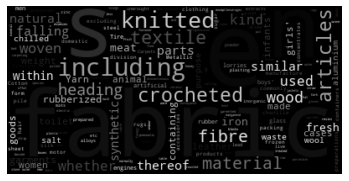

In [142]:
wc = WordCloud(collocations = False, colormap = "Greys").generate(" ".join(inv_partition[0]))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

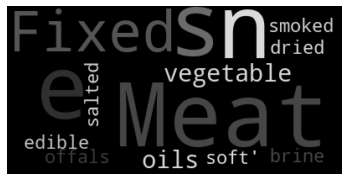

In [143]:
wc = WordCloud(collocations = False, colormap = "Greys").generate(" ".join(inv_partition[1]))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

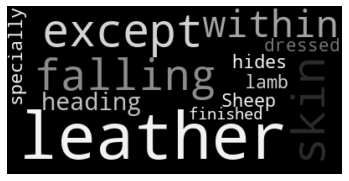

In [144]:
wc = WordCloud(collocations = False, colormap = "Greys").generate(" ".join(inv_partition[2]))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

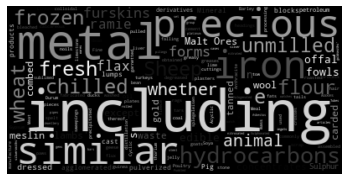

In [145]:
wc = WordCloud(collocations = False, colormap = "Greys").generate(" ".join(inv_partition[3]))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

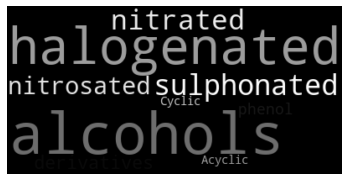

In [146]:
wc = WordCloud(collocations = False, colormap = "Greys").generate(" ".join(inv_partition[4]))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

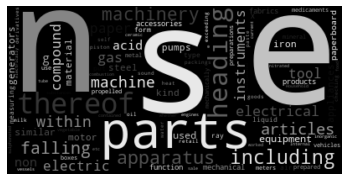

In [147]:
wc = WordCloud(collocations = False, colormap = "Greys").generate(" ".join(inv_partition[5]))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

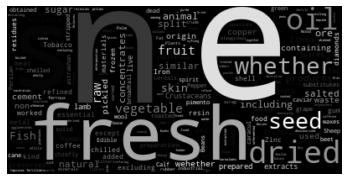

In [148]:
wc = WordCloud(collocations = False, colormap = "Greys").generate(" ".join(inv_partition[6]))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

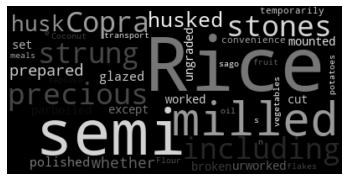

In [149]:
wc = WordCloud(collocations = False, colormap = "Greys").generate(" ".join(inv_partition[7]))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

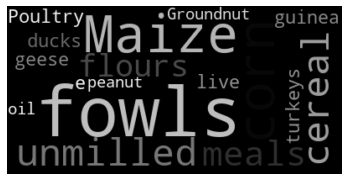

In [150]:
wc = WordCloud(collocations = False, colormap = "Greys").generate(" ".join(inv_partition[8]))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

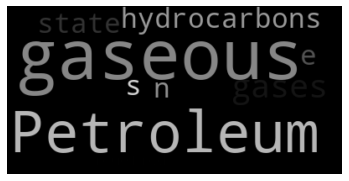

In [151]:
wc = WordCloud(collocations = False, colormap = "Greys").generate(" ".join(inv_partition[9]))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [152]:
inv_partition[1]

['Meat and edible meat offals, n.e.s., salted, in brine, dried or smoked',
 'Fixed vegetable oils, n.e.s.',
 "Other 'soft' fixed vegetable oils"]

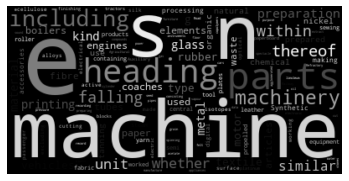

In [153]:
wc = WordCloud(collocations = False, colormap = "Greys").generate(" ".join(inv_partition[10]))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

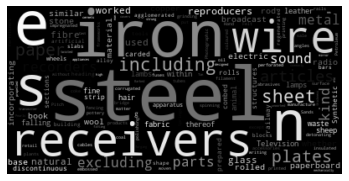

In [155]:
wc = WordCloud(collocations = False, colormap = "Greys").generate(" ".join(inv_partition[11]))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

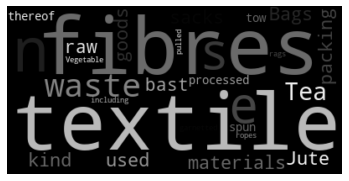

In [156]:
wc = WordCloud(collocations = False, colormap = "Greys").generate(" ".join(inv_partition[12]))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

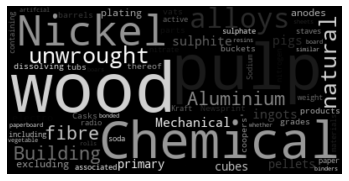

In [157]:
wc = WordCloud(collocations = False, colormap = "Greys").generate(" ".join(inv_partition[13]))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [158]:
wc = WordCloud(collocations = False, colormap = "Greys").generate(" ".join(inv_partition[14]))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

KeyError: 14